## Decision Support System (DSS) Span Analysis ##

https://github.com/jupyter/docker-stacks  
https://hub.docker.com/r/jupyter/r-notebook/tags/  

_(optional) docker pull jupyter/r-notebook:latest_  

We want to make the DDS Prototype ~/analysis/ directory linked to the Juypter container. Use the following to mount the analysis directory (i.e. current working directory) as a volume in the Juypter container. Note that the directory needed to be added via the Docker Desktop Dashboard on Mac.

_docker run -it --rm -d -p 10000:8888 -v ${PWD}:/home/jovyan/work --name notebook jupyter/r-notebook:latest_  

To find the token from the container:  
_docker exec -it notebook jupyter server list_

Navigate to the container UI and enter the token:
http://localhost:10000

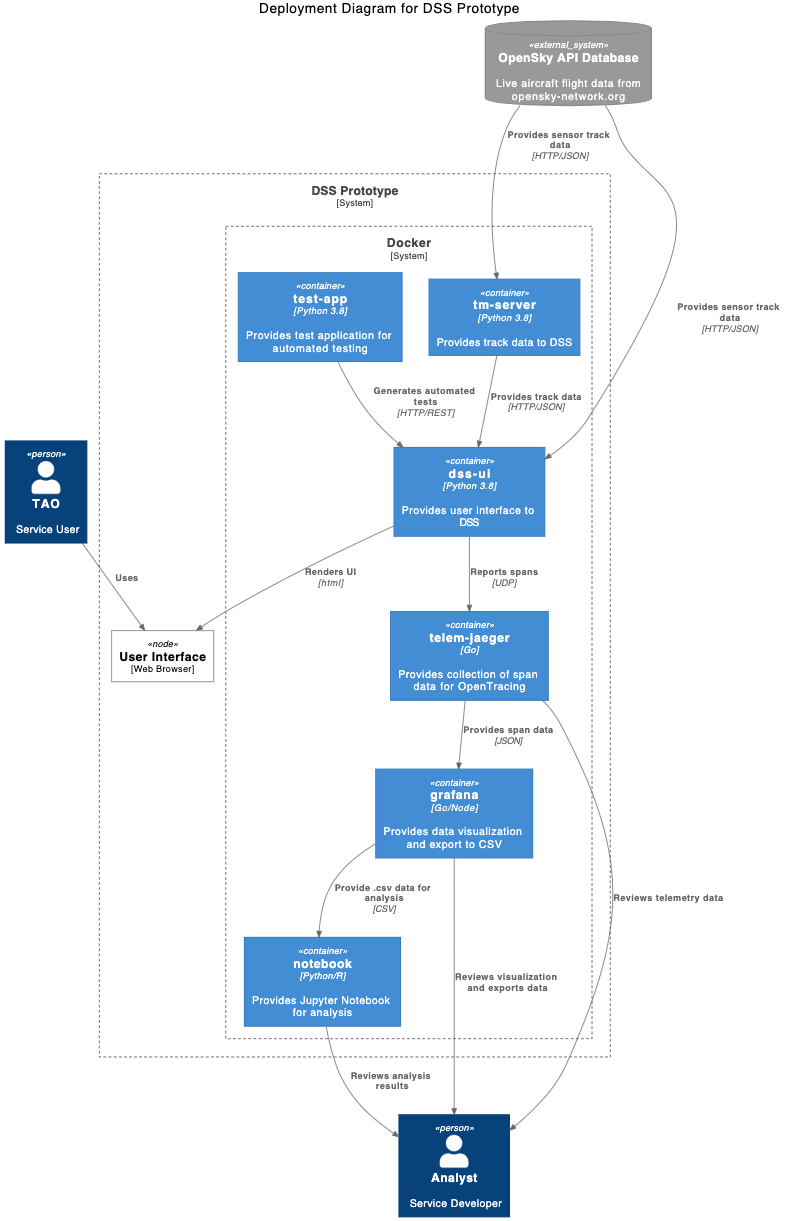

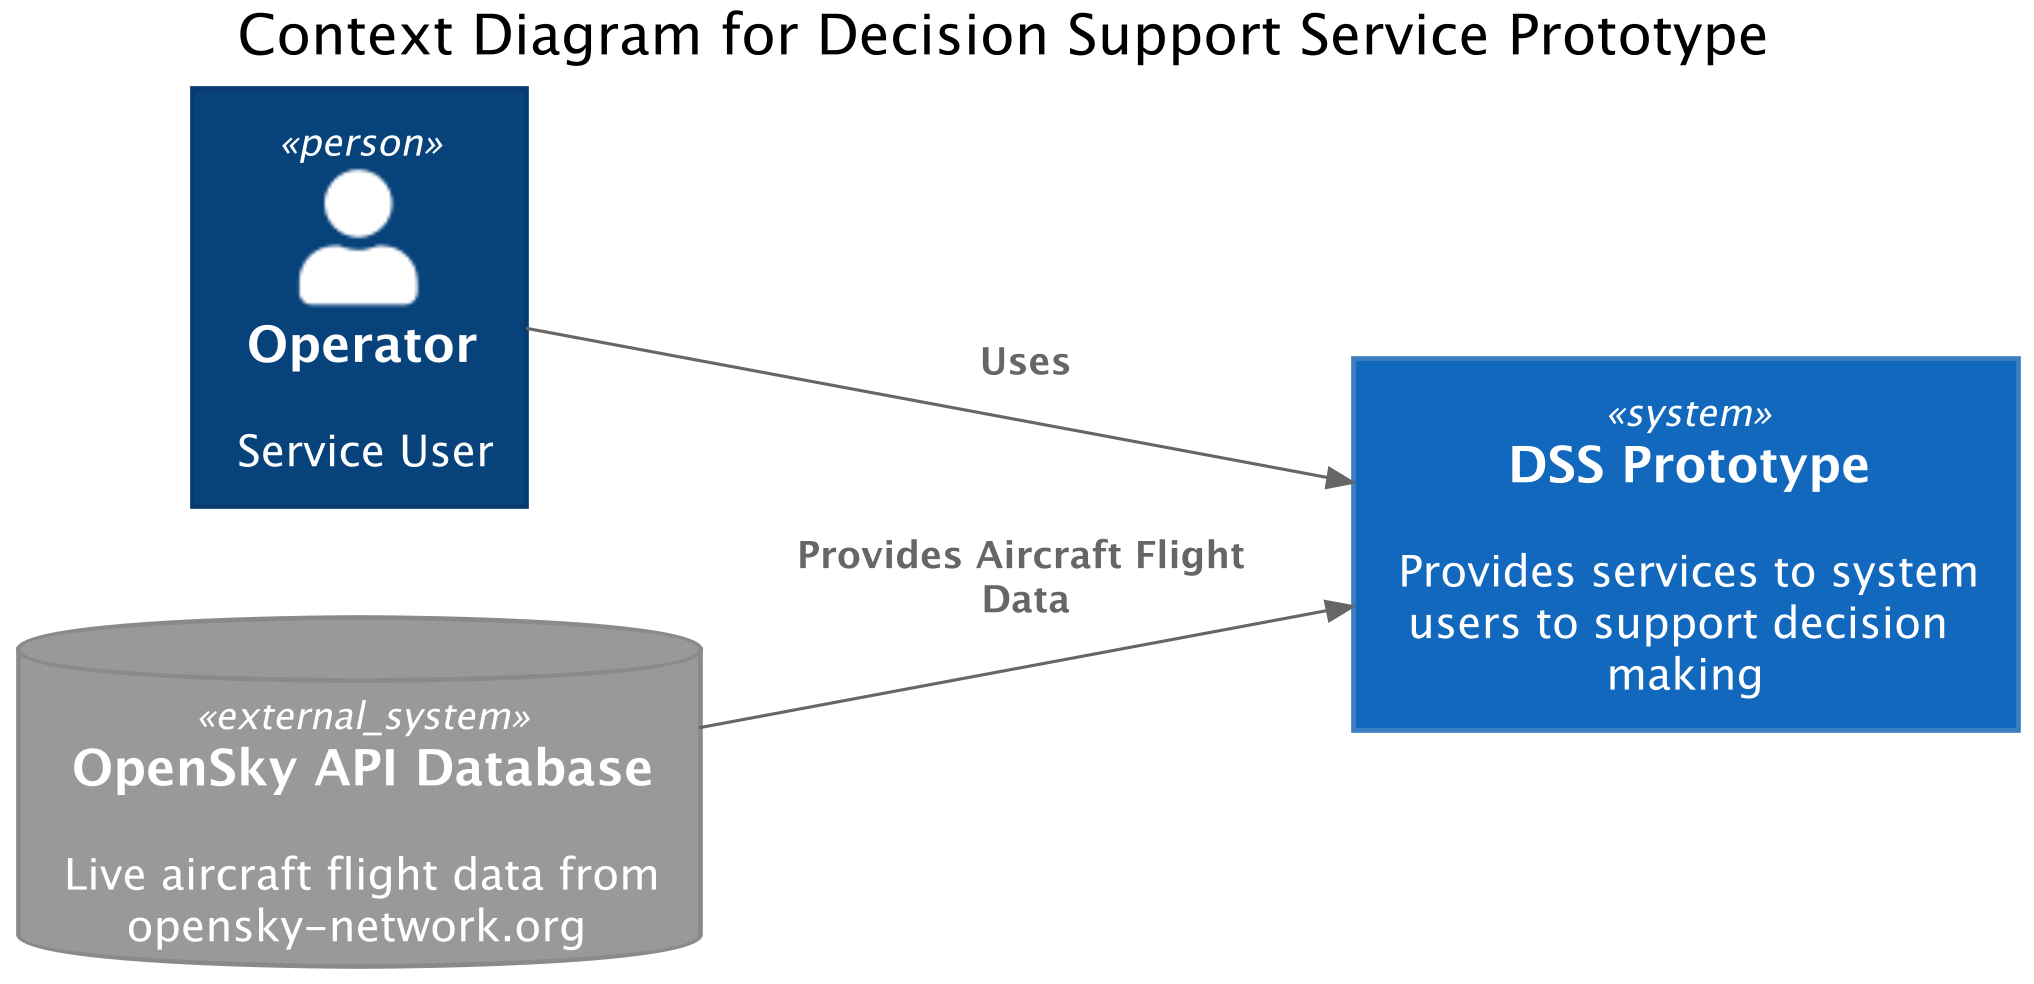

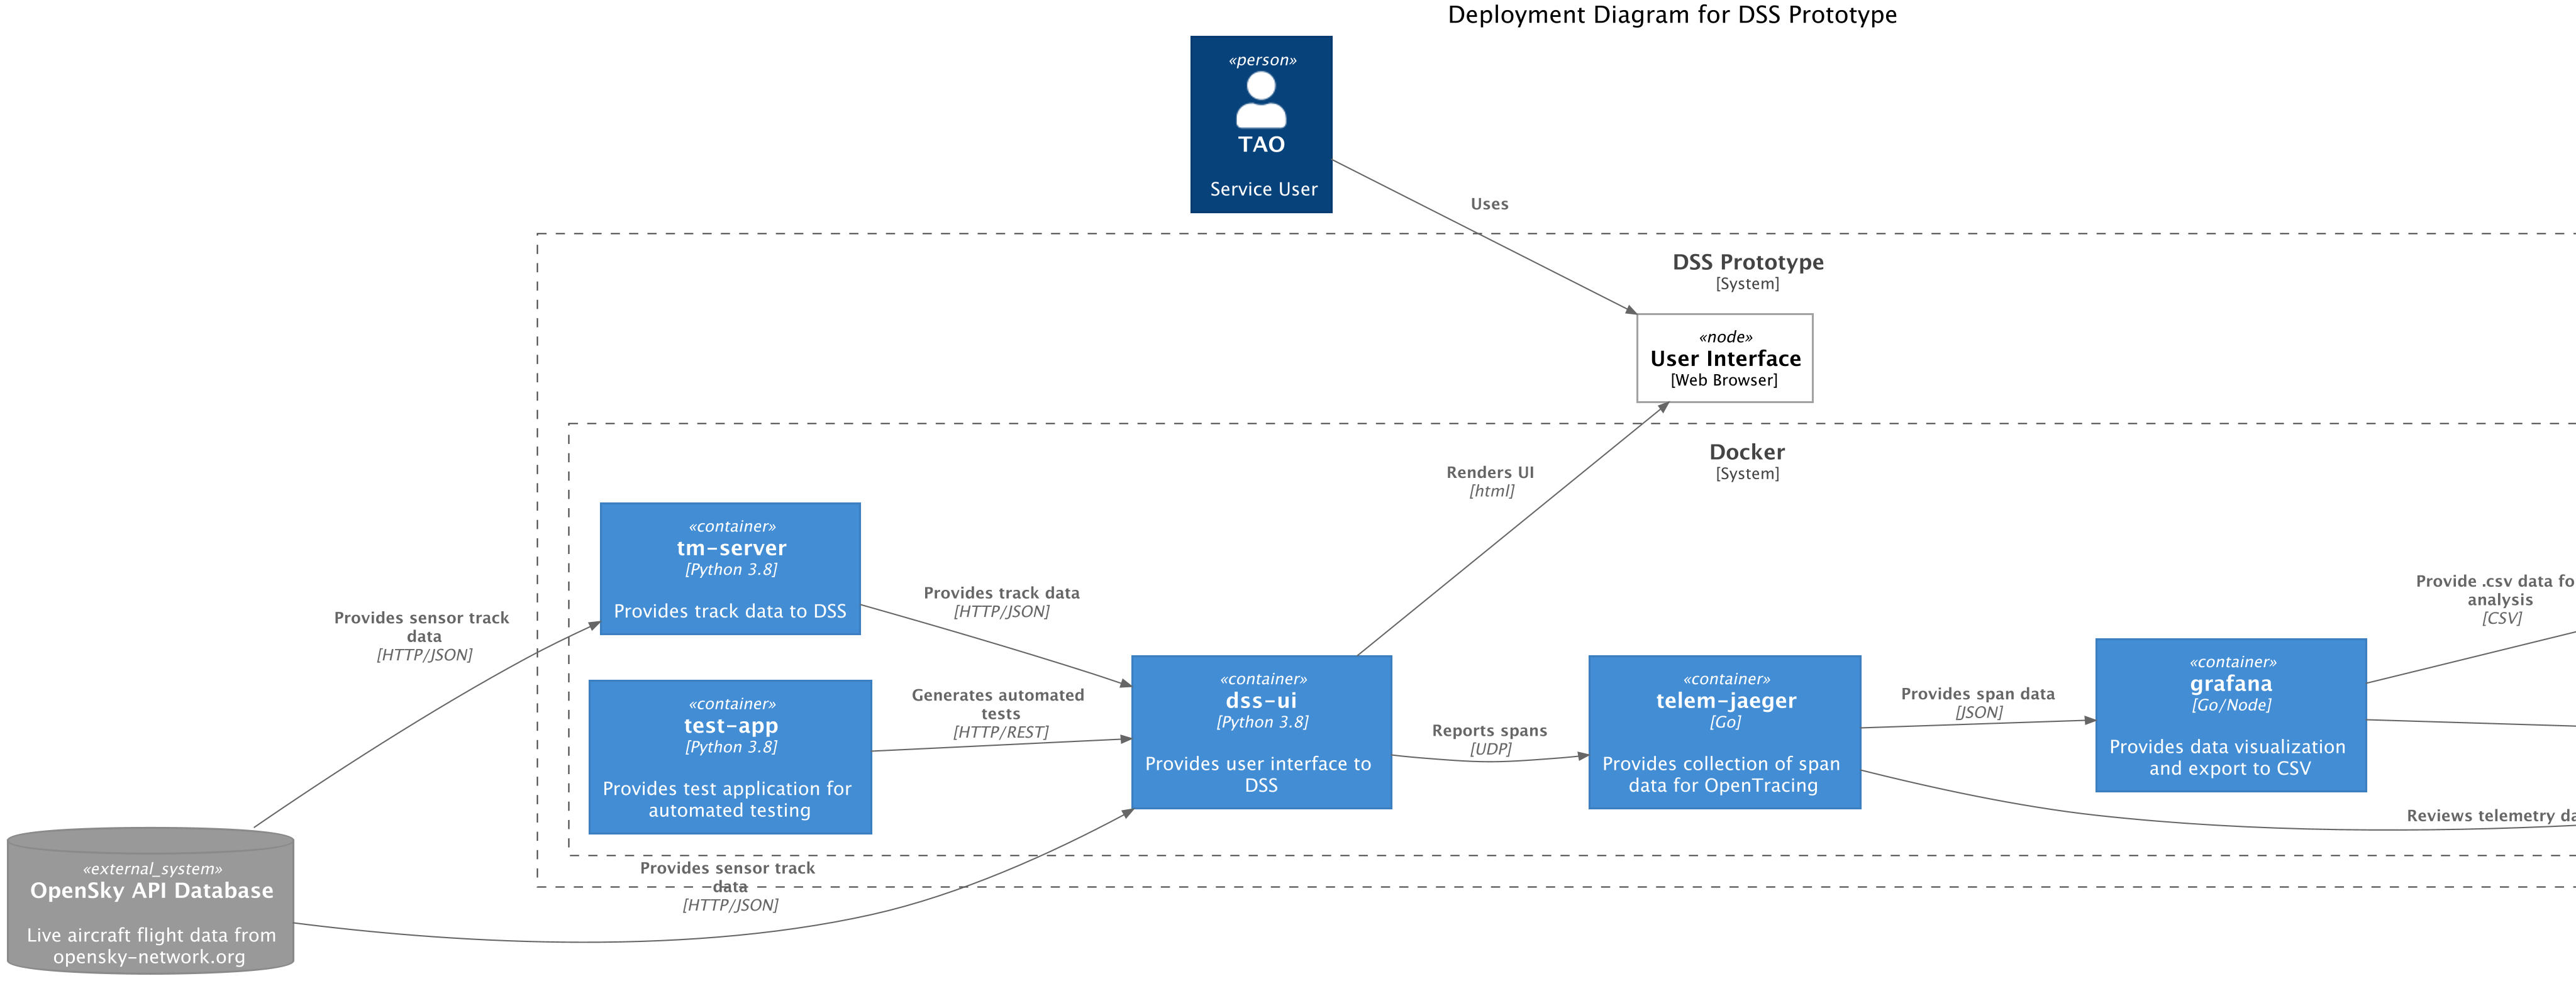

In [1]:
install.packages("stringr")                # Install stringr package in R
library("stringr")                         # Load stringr package

Updating HTML index of packages in '.Library'

Making 'packages.html' ...
 done



In [2]:
setwd('/home/jovyan/work/data')

In [3]:
options(warn=-1)
spanData <- read.csv('DSS Spans-data-2022-03-21 16_09_42.csv', header = TRUE)
attach(spanData)

# Exploratory Data Analysis #

In [4]:
head(spanData)

,Trace.ID,Trace.name,Start.time,Duration
,<chr>,<chr>,<chr>,<chr>
1,ba0a16b1a5d684ef0e6d75150d6ff69b,dss-prototype: /tracks,2022-03-21 15:50:31.385,4.39 ms
2,9d4abad7fbccf9b2c57f069ee74b9179,dss-prototype: /tracks,2022-03-21 15:50:30.376,4.49 ms
3,4175db7882fdc38fc78874d8e99678ac,dss-prototype: /tracks,2022-03-21 15:50:29.368,4.51 ms
4,36d2da96f77f08800521d38cfb0a057b,dss-prototype: /tracks,2022-03-21 15:50:28.360,4.62 ms
5,a0e30170f95d99d91ea3ecb48fdb11ac,dss-prototype: /tracks,2022-03-21 15:50:27.351,4.55 ms
6,306d997c50f62360856b902fd8a96815,dss-prototype: /tracks,2022-03-21 15:50:26.343,4.34 ms


In [5]:
summary(spanData)

   Trace.ID          Trace.name         Start.time          Duration        
 Length:100         Length:100         Length:100         Length:100        
 Class :character   Class :character   Class :character   Class :character  
 Mode  :character   Mode  :character   Mode  :character   Mode  :character  

In [6]:
# Convert character data into numeric metrics

spanMetrics <- spanData

for(i in 1:nrow(spanMetrics)) {       # for-loop over rows
    
    # Convert span duration
    
    char = spanMetrics[i,4]
    len = str_length(char)
    duration = str_sub(char,1,(len-3))
    units = str_sub(char,(len-1),len)
    duration = as.numeric(duration)

    if(units == 'ms') {
        duration = duration / 1000              # Convert to ms
    } else if (units == 'µs') {
        duration = duration / 1000000           # Convert to µs
    } else if (units == ' s') {
        duration = duration
    } else {
        print ('Unable to find specified units')
        print (units)
    }
    spanMetrics[i,4] = duration
    
    # Convert time

    time = spanMetrics[i,3]
    epoch <- as.POSIXct(time)
    epoch_int <- as.integer(epoch)
    spanMetrics[i,3] = epoch_int
}

# Convert columns for char to numeric

spanMetrics$Duration = as.numeric(spanMetrics$Duration)
spanMetrics$Start.time = as.numeric(spanMetrics$Start.time)

head(spanMetrics)
tail(spanMetrics)
summary(spanMetrics)

,Trace.ID,Trace.name,Start.time,Duration
,<chr>,<chr>,<dbl>,<dbl>
1,ba0a16b1a5d684ef0e6d75150d6ff69b,dss-prototype: /tracks,1647877831,0.00439
2,9d4abad7fbccf9b2c57f069ee74b9179,dss-prototype: /tracks,1647877830,0.00449
3,4175db7882fdc38fc78874d8e99678ac,dss-prototype: /tracks,1647877829,0.00451
4,36d2da96f77f08800521d38cfb0a057b,dss-prototype: /tracks,1647877828,0.00462
5,a0e30170f95d99d91ea3ecb48fdb11ac,dss-prototype: /tracks,1647877827,0.00455
6,306d997c50f62360856b902fd8a96815,dss-prototype: /tracks,1647877826,0.00434


,Trace.ID,Trace.name,Start.time,Duration
,<chr>,<chr>,<dbl>,<dbl>
95,38d36208e7942032fac6806f5596555f,dss-prototype: /RIC,1647877467,0.402
96,4b33a2e6c3d2f4f789d78cc12532d2c1,dss-prototype: /IAD,1647877466,0.382
97,13b1f8fbca3070eb911e9965b118b7c0,dss-prototype: /RIC,1647877464,0.404
98,5544f55eda5f2672fa6997a7a5f61a0d,dss-prototype: /IAD,1647877463,0.449
99,ae5ed1bf7e76209cb1608c7ac012b0ab,dss-prototype: /RIC,1647877461,0.382
100,54ad2c2c9b240efb50f2057a8081b9a1,dss-prototype: /IAD,1647877460,0.356


   Trace.ID          Trace.name          Start.time           Duration       
 Length:100         Length:100         Min.   :1.648e+09   Min.   :0.004250  
 Class :character   Class :character   1st Qu.:1.648e+09   1st Qu.:0.004488  
 Mode  :character   Mode  :character   Median :1.648e+09   Median :0.004690  
                                       Mean   :1.648e+09   Mean   :0.176414  
                                       3rd Qu.:1.648e+09   3rd Qu.:0.367000  
                                       Max.   :1.648e+09   Max.   :1.700000  

## Search for outliers

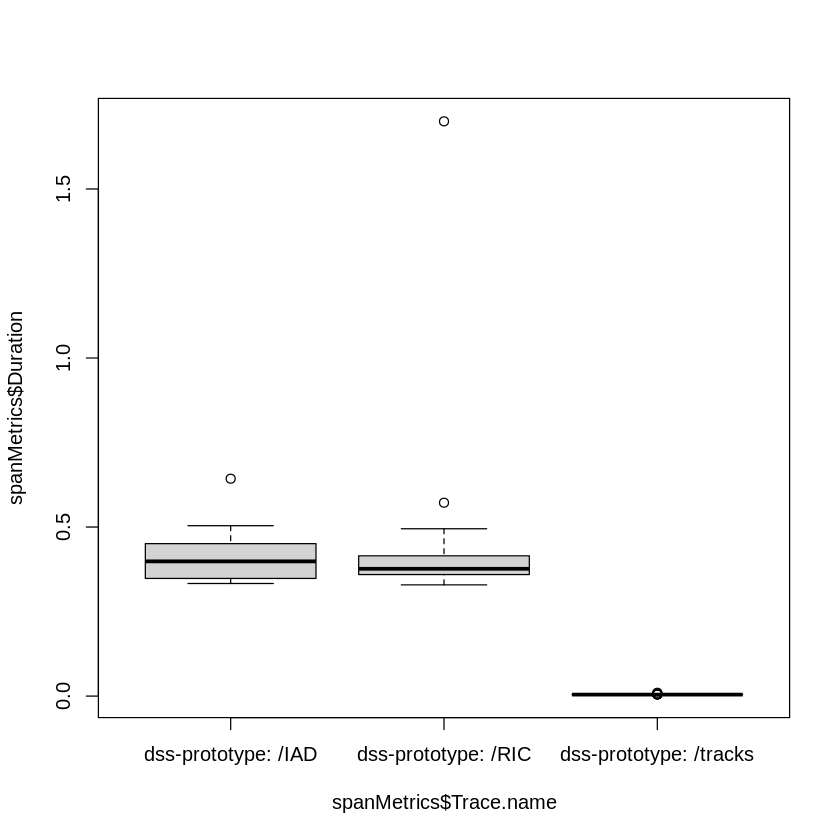

In [7]:
boxplot(spanMetrics$Duration~spanMetrics$Trace.name)

In [8]:
## Use this to get the values of the statistical outliers in trk_update_data from R
outliers <- boxplot(spanMetrics$Duration, plot = FALSE)$out
outliers
# spanMetrics$Duration[which(spanMetrics$Duration %in% outliers),]

[1] 1.7

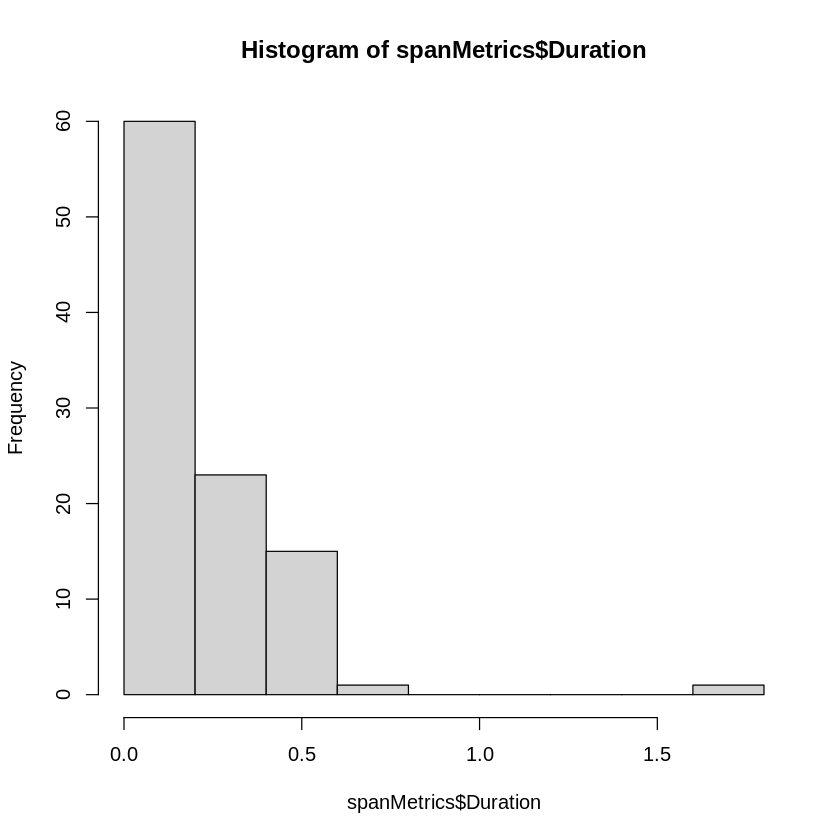

In [9]:
# par(mfrow=c(2,2))

hist(spanMetrics$Duration)

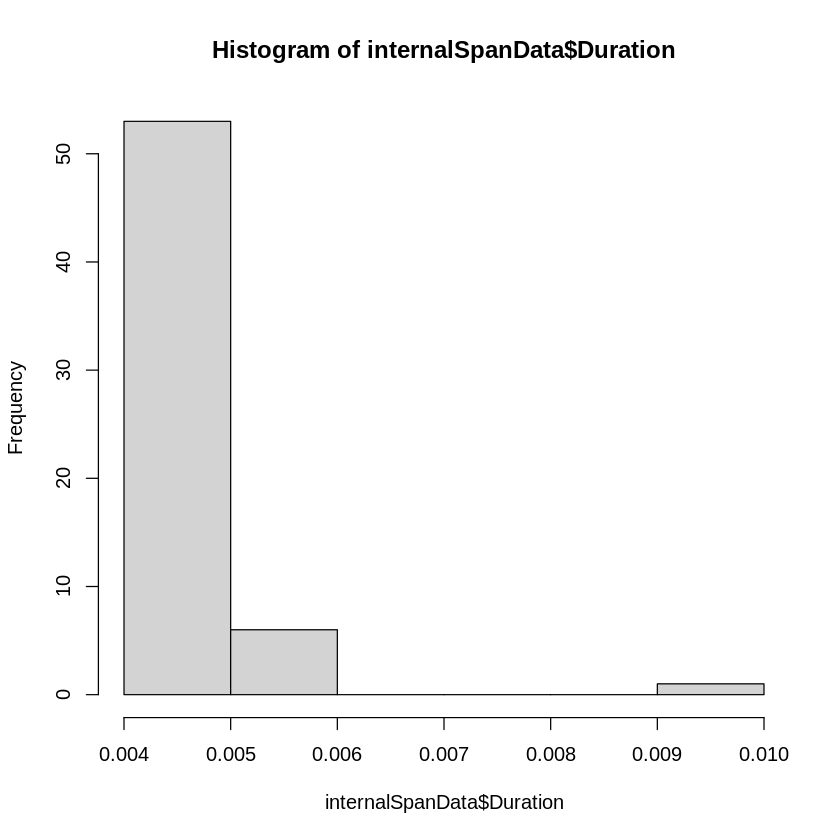

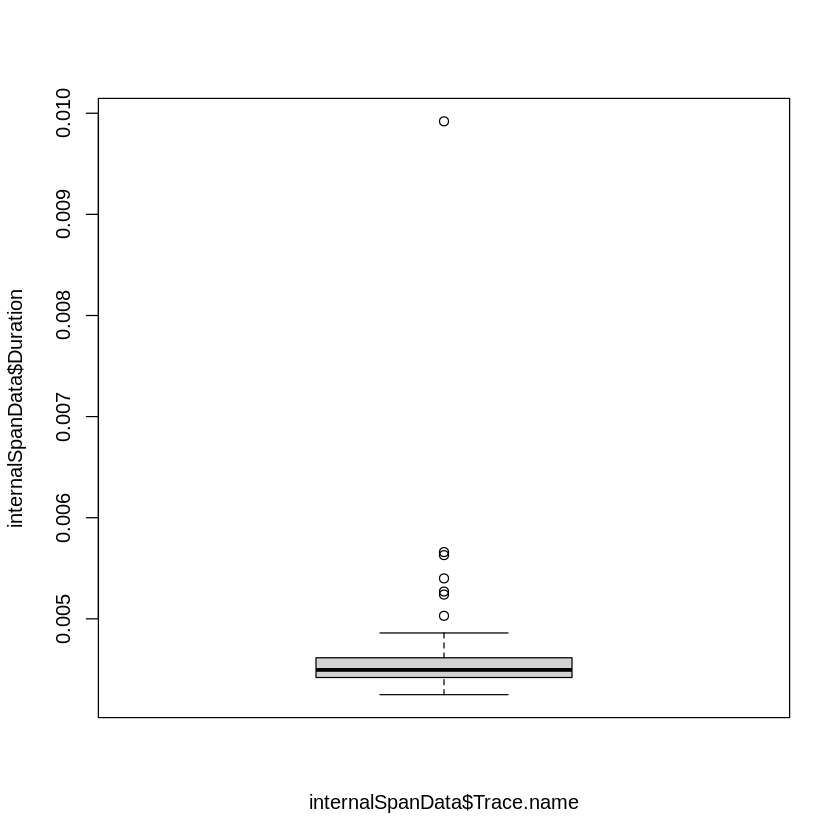

In [10]:
internalSpanData = subset(spanMetrics, Trace.name == "dss-prototype: /tracks")
hist(internalSpanData$Duration)
boxplot(internalSpanData$Duration~internalSpanData$Trace.name)

In [11]:
outliers <- boxplot(internalSpanData$Duration, plot = FALSE)$out
outliers
# internalSpanData$Duration[which(internalSpanData$Duration %in% outliers),]

[1] 0.00524 0.00566 0.00527 0.00503 0.00540 0.00563 0.00992

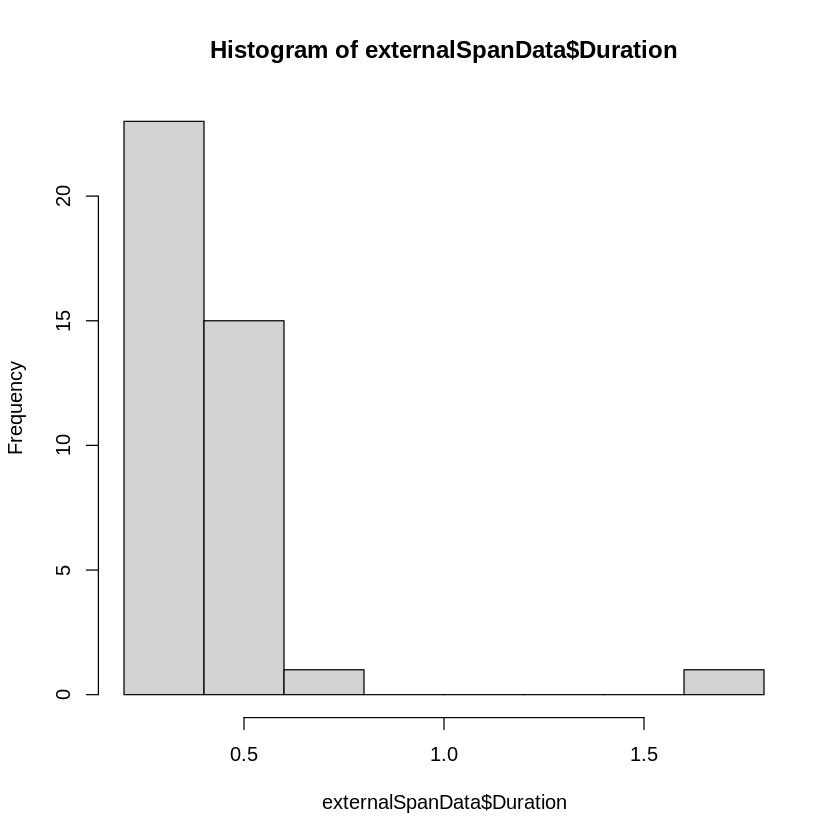

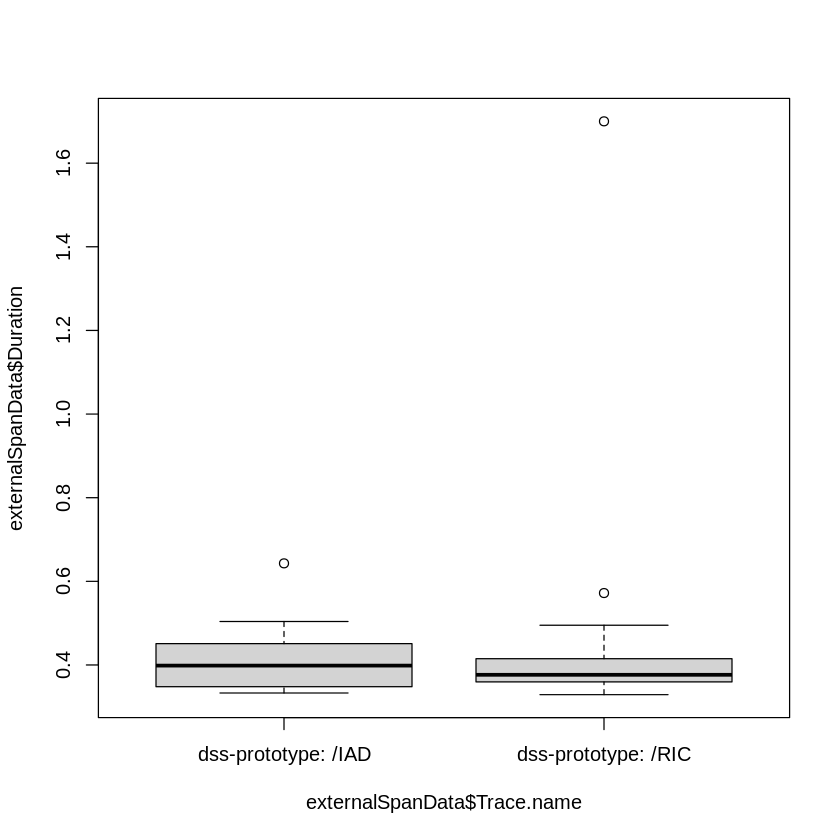

In [12]:
externalSpanData = subset(spanMetrics, Trace.name != "dss-prototype: /tracks")
hist(externalSpanData$Duration)
boxplot(externalSpanData$Duration~externalSpanData$Trace.name)

In [13]:
outliers <- boxplot(externalSpanData$Duration, plot = FALSE)$out
outliers

[1] 0.643 1.700 0.572

## Q-Q Plot

The Q-Q plot, or quantile-quantile plot, is a graphical tool to help us assess if a set of data plausibly came from some theoretical distribution such as a normal or exponential. A Q-Q plot is a scatterplot created by plotting two sets of quantiles against one another. If both sets of quantiles came from the same distribution, we should see the points forming a line that’s roughly straight.

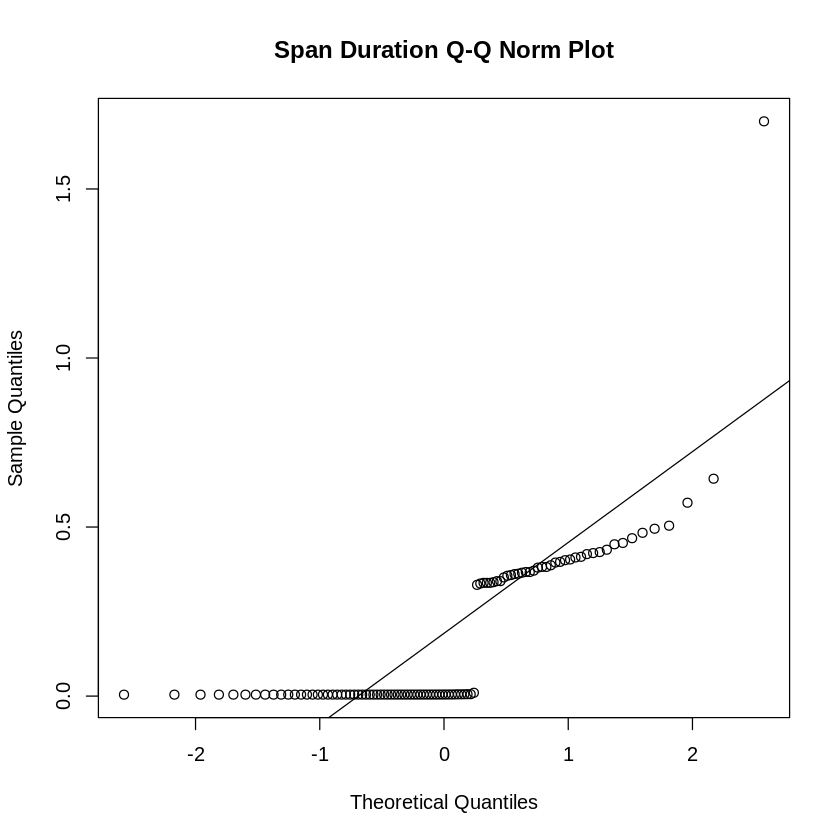

In [14]:
qqnorm(spanMetrics$Duration,main="Span Duration Q-Q Norm Plot")
qqline(spanMetrics$Duration)

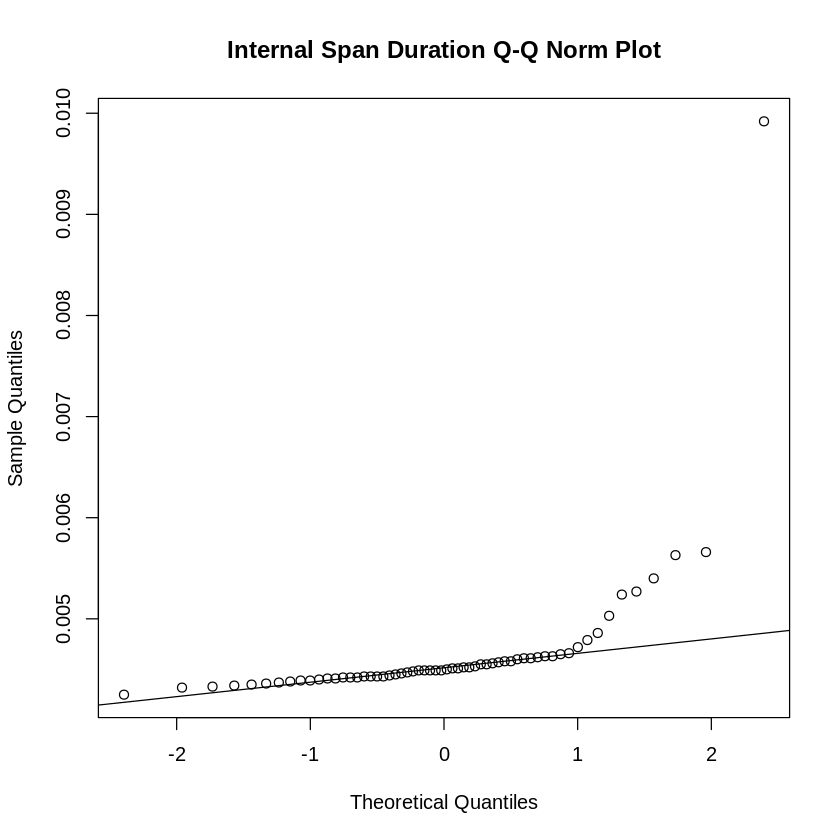

In [15]:
qqnorm(internalSpanData$Duration,main="Internal Span Duration Q-Q Norm Plot")
qqline(internalSpanData$Duration)

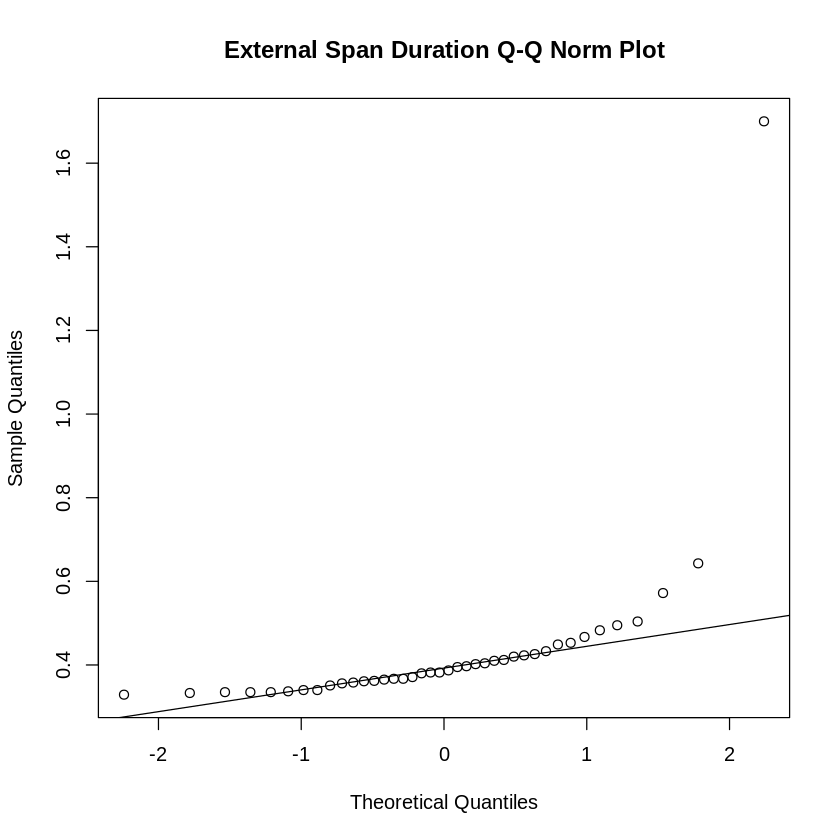

In [16]:
qqnorm(externalSpanData$Duration,main="External Span Duration Q-Q Norm Plot")
qqline(externalSpanData$Duration)

## Autocorrelation ##

Autocorrelation plots are a commonly-used tool for checking randomness in a data set. This randomness is ascertained by computing autocorrelations for data values at varying time lags. If random, such autocorrelations should be near zero for any and all time-lag separations. If non-random, then one or more of the autocorrelations will be significantly non-zero.

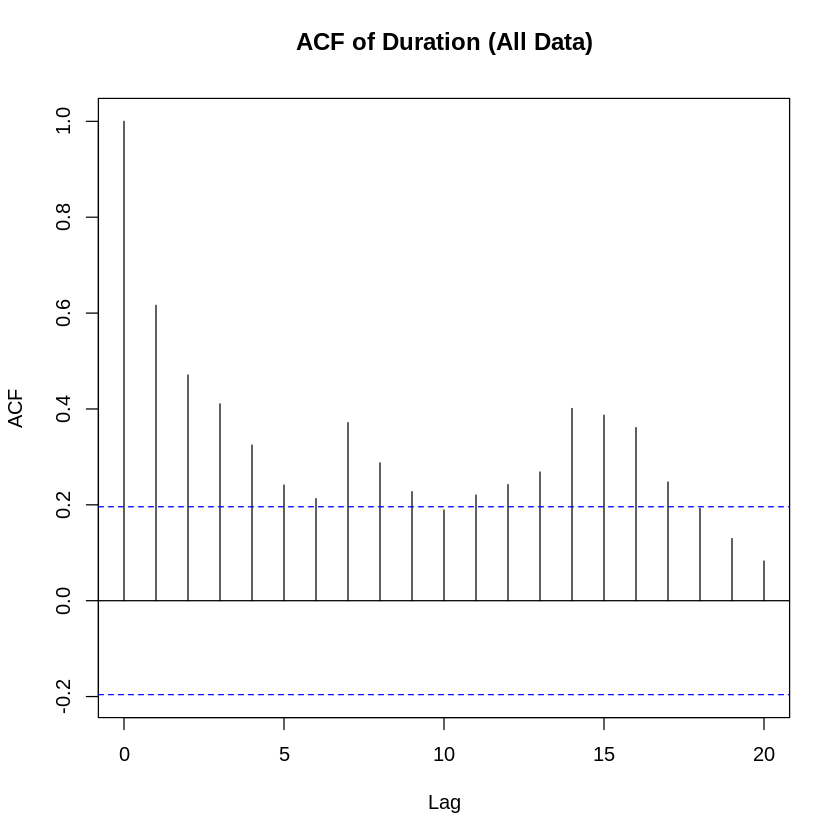

In [17]:
acf(spanMetrics$Duration, main="ACF of Duration (All Data)")

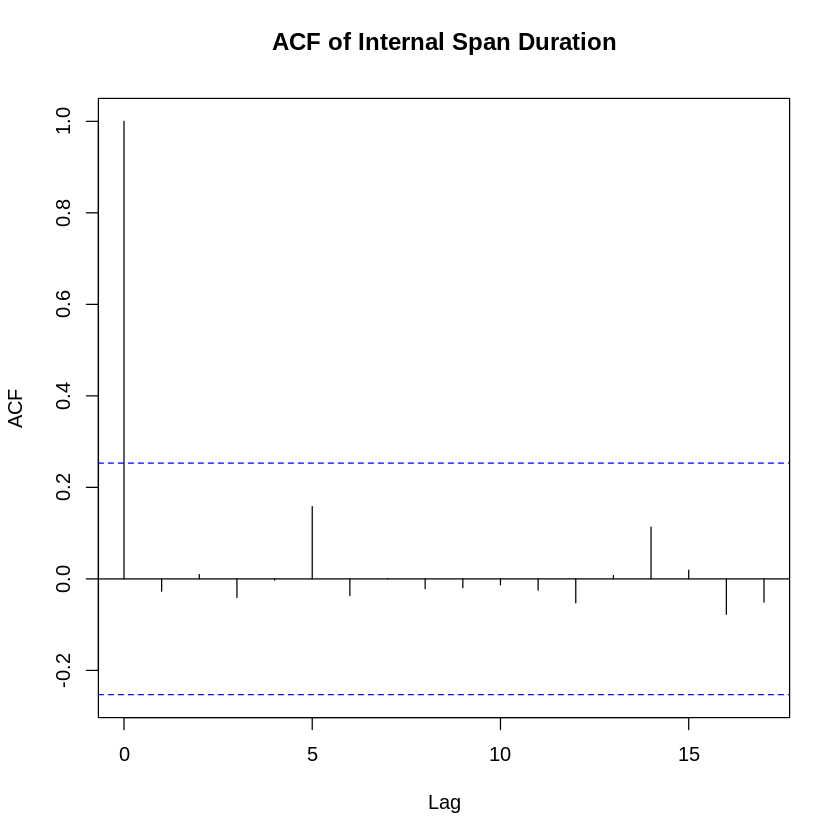

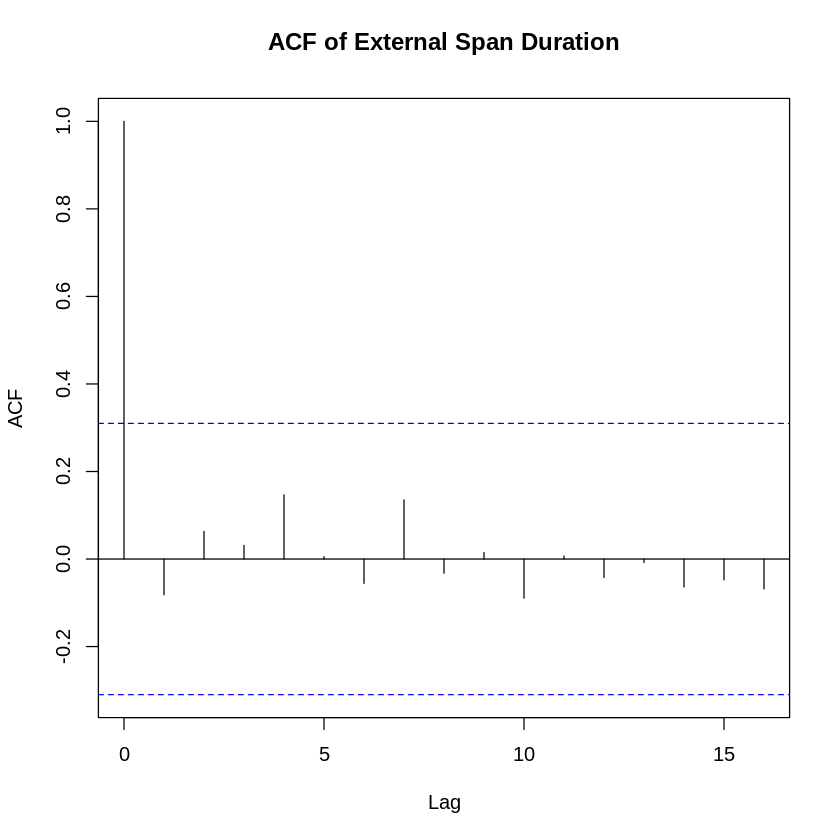

In [18]:
acf(internalSpanData$Duration, main="ACF of Internal Span Duration")
acf(externalSpanData$Duration, main="ACF of External Span Duration")

# Hypothesis Testing # 

Modern DevSecOps architectures can be designed to meet hard-real-time latency (μ) requirements using modern computing environments and computing infrastructure:

H0: μ ≤ tbd ms with jitter within latency bounds  
Ha: μ > tbd ms with jitter exceeding latency bounds  
∝ = 0.05

We will use 500 ms; i.e. tbd will be set to 0.5.



## Shapiro test to establish normality

Null hypothesis: the data are normally distributed  
Alternative hypothesis: the data are not normally distributed

### First let's look at the entire data set

In [19]:
shapiro.test(spanMetrics$Duration)


	Shapiro-Wilk normality test

data:  spanMetrics$Duration
W = 0.64872, p-value = 4.005e-14


**REVIEW** p-value = 4.005e-14 < 0.05; **UPDATE: fail to reject the null hypothesis that the data is normally distributed.**

### Now just looking at the internal spans ###

In [20]:
shapiro.test(internalSpanData$Duration)


	Shapiro-Wilk normality test

data:  internalSpanData$Duration
W = 0.36994, p-value = 1.302e-14


**REVIEW** p-value = 1.302e-14 < 0.05; **UPDATE: fail to reject the null hypothesis that the data is normally distributed.**

In [21]:
shapiro.test(externalSpanData$Duration)


	Shapiro-Wilk normality test

data:  externalSpanData$Duration
W = 0.38541, p-value = 9.495e-12


**REVIEW** p-value = 9.495e-12 < 0.05; **UPDATE: fail to reject the null hypothesis that the data is normally distributed.**

## T-Test ##

In [22]:
x = spanMetrics$Duration
t.test(x=x, mu=0.5, alternative = 'greater')


	One Sample t-test

data:  x
t = -12.885, df = 99, p-value = 1
alternative hypothesis: true mean is greater than 0.5
95 percent confidence interval:
 0.1347159       Inf
sample estimates:
mean of x 
0.1764144 


In [23]:
x = internalSpanData$Duration
t.test(x=x, mu=0.5, alternative = 'greater')


	One Sample t-test

data:  x
t = -5118.1, df = 59, p-value = 1
alternative hypothesis: true mean is greater than 0.5
95 percent confidence interval:
 0.004512274         Inf
sample estimates:
mean of x 
 0.004674 


In [24]:
x = externalSpanData$Duration
t.test(x=x, mu=0.5, alternative = 'greater')


	One Sample t-test

data:  x
t = -1.9317, df = 39, p-value = 0.9697
alternative hypothesis: true mean is greater than 0.5
95 percent confidence interval:
 0.3764811       Inf
sample estimates:
mean of x 
 0.434025 
